
#### Research Questions:
#### RQ1a: Do concept-based interventions reduce cheating behavior?
#### RQ1b: Do the effects on cheating vary by concepts?
#### RQ2a: Do the interventions affect performance and user experience?
#### RQ2b: Do the effects on performance and experience vary by concepts?
#### RQ3: How do concept-based interventions influence cheating behavior, performance and user experience?


In [ ]:
# ============================================================================
# PROJECT FOLDER STRUCTURE
# ============================================================================

# game-behavior-analytics/
# ├── data/
# │   └── final_dataset.xlsx              # Research dataset
# ├── src/
# │   ├── data/
# │   │   ├── data_loader.py             # Load and validate data
# │   │   └── preprocessor.py            # Create derived variables
# │   ├── models/
# │   │   ├── cheating_model.py          # Bayesian cheating analysis
# │   │   ├── performance_model.py       # Performance/experience analysis
# │   │   └── pathway_model.py          # Mediation/moderation analysis
# │   │   └── network_model.py          # Psychological Network analysis
# │   └── visualization/
# │       └── plots.py                   # All plotting functions
# └── notebooks/
#     └── analysis.ipynb                 # Main analysis notebook

### 1. SETUP LIBRARIES AND DATA PREPARATION
PURPOSE: 
- (1.2) Import libraries, load raw dataset and create analysis-ready variables
    - Loads final_dataset.xlsx with participant responses
    - Creates cheating_behavior categories (0=non, 1=partial, 2=full cheater)
    - Creates composite experience variable from satisfaction + engagement
    - Prepares categorical codes for statistical modeling
    - Validates data quality and handles missing values

- (1.3) Explore raw data patterns before statistical modeling
    - Shows cheating distributions: control vs intervention groups
    - Displays performance and experience distributions by cheating behavior
    - Creates Figure 1: Cheating rates comparison (46.6% control vs 36.7% intervention)
    - Provides initial evidence that interventions reduce cheating
    - Sets foundation for formal hypothesis testing in RQ1-RQ3


In [1]:
# ============================================================================
# 1.1. PROJECT SETUP
# ============================================================================

import sys
import os
sys.path.append('../')
import warnings
warnings.filterwarnings('ignore')

# Change to the correct directory
os.chdir('game-behavior-analytics/data_analysis_notebook/')

In [2]:
# ============================================================================
# 1.2. DATA LOADING AND PREPARATION
# ============================================================================

from src.data.data_loader import load_and_validate_data
from src.data.preprocessor import preprocess_data

print("CHEATING INTERVENTION ANALYSIS")
print("=" * 60)

# Load and preprocess data
df_raw = load_and_validate_data()
df, encoding_info = preprocess_data(df_raw)

print(f"\nDataset ready: {len(df)} participants")
print(f"Intervention concepts: {len(encoding_info['concepts'])}")

CHEATING INTERVENTION ANALYSIS
Dataset loaded: 1282 participants, 62 variables
Cleaned: 50 participants removed, 1232 remaining
Preprocessing complete: 15 intervention concepts
Control group: 73 participants

Dataset ready: 1232 participants
Intervention concepts: 15



OUTCOMES PLOTS: Cheating Behavior, Performance, and Experience


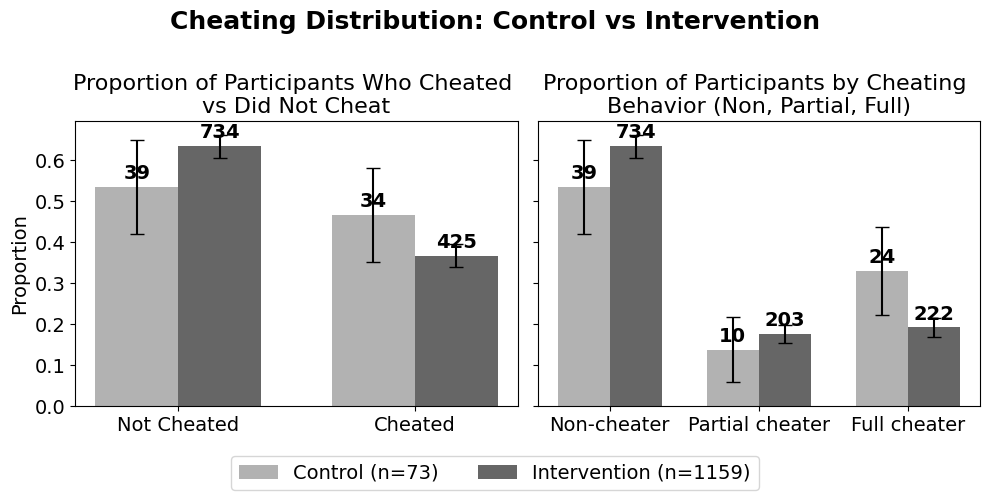

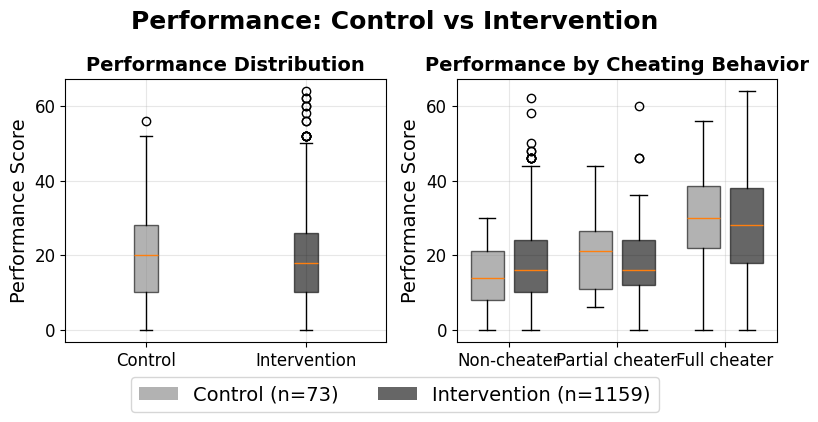

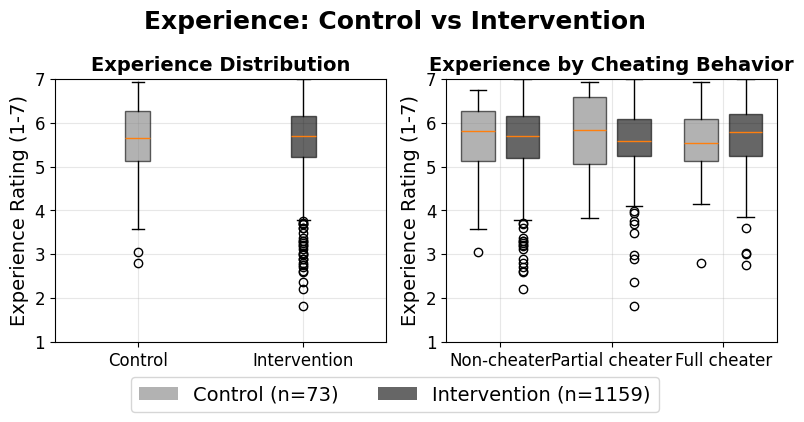


CORRELATION ANALYSIS: PERFORMANCE AND EXPERIENCE
Performance-Experience Correlations by Group and Cheating Category:
       Group Cheating Category   n  Correlation
     Control      Non-cheaters  39        0.339
     Control  Partial cheaters  10       -0.427
     Control     Full cheaters  24        0.203
Intervention      Non-cheaters 734        0.115
Intervention  Partial cheaters 203        0.006
Intervention     Full cheaters 222        0.222


In [3]:
# ============================================================================
# 1.3. DESCRIPTIVE ANALYSIS
# ============================================================================

from src.visualization.plots import plot_descriptive_stats
import pandas as pd

print("\n" + "=" * 60)
print("OUTCOMES PLOTS: Cheating Behavior, Performance, and Experience")
print("=" * 60)

plot_descriptive_stats(df)

print("\n" + "=" * 80)
print("CORRELATION ANALYSIS: PERFORMANCE AND EXPERIENCE")
print("=" * 80)

# Calculate correlations by subgroup for model selection (replicating original analysis)
corr_results = []
cheating_labels = {0: 'Non-cheaters', 1: 'Partial cheaters', 2: 'Full cheaters'}

for group_name, group_data in [('Control', df[df['concept'] == 'control']), 
                               ('Intervention', df[df['concept'] != 'control'])]:
    for cheat_cat in [0, 1, 2]:
        subset = group_data[group_data['cheating_behavior'] == cheat_cat]
        if len(subset) >= 10:
            corr = subset[['performance', 'experience']].corr().iloc[0, 1]
        else:
            corr = None
        corr_results.append({
            'Group': group_name,
            'Cheating Category': cheating_labels[cheat_cat],
            'n': len(subset),
            'Correlation': round(corr, 3) if corr is not None else 'NA'
        })

# Display correlation table
corr_table = pd.DataFrame(corr_results)
print("Performance-Experience Correlations by Group and Cheating Category:")
print(corr_table.to_string(index=False))

### 2. RQ1: CHEATING BEHAVIOR ANALYSIS

Answers these two research questions ~
- #### RQ1a: Do concept-based interventions reduce cheating behavior?
- #### RQ1b: Do the effects on cheating vary by concepts?


We do this by:
- (2.1) Fits Bayesian multinomial logistic regression (3 cheating categories)
    - Controls for motivational message variations through random effects
    - Uses empirical priors from control group baseline rates
    - Tests 15 intervention concepts across 4 psychological theories
    - Provides diagnostic checks for model fit and convergence
- (2.2) Analyzes model results to answer RQ1a and RQ1b
    - Produces Figure: Overall intervention effects
    - Produces Figure: Concept-specific effects



In [4]:
# ==========================================================================================
# 2.1. CHEATING BEHAVIOR MODEL FITTING (BAYESIAN MULTINOMIAL LOGISTIC REGRESSION)
# ==========================================================================================

"""
REGRESSION EQUATION FOR CHEATING BEHAVIOR MODEL:

Multinomial Logistic Regression (3 categories: Non-cheater=0, Partial cheater=1, Full cheater=2)

log(P(Partial)/P(Non)) = β₀_partial + Σ(αᵢ x Conceptᵢ) + γⱼ x Messageⱼ
log(P(Full)/P(Non))    = β₀_full + Σ(δᵢ x Conceptᵢ) + ηⱼ x Messageⱼ

Where:
- Dependent Variable: cheating_behavior (0=Non-cheater, 1=Partial cheater, 2=Full cheater)
- Independent Variables:
  * Conceptᵢ: Dummy variables for 15 intervention concepts (reference = control)
  * Messageⱼ: Random effects for motivational message variations
- Parameters:
  * β₀_partial, β₀_full: Control group baselines (empirical priors)
  * αᵢ, δᵢ: Concept effects on partial/full cheating
  * γⱼ, ηⱼ: Random message effects

Model uses empirical Bayesian priors from control group and handles missing concepts
through indicator variables.
"""

from src.models.cheating_model import analyze_cheating_behavior

cheating_trace, cheating_effects = analyze_cheating_behavior(df, encoding_info)

Fitting cheating behavior model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_partial_intercept, beta_full_intercept, concept_effects_partial, concept_effects_full, message_effects_partial, message_effects_full]
Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 11 seconds.


✓ Cheating model completed



MODEL DIAGNOSTICS


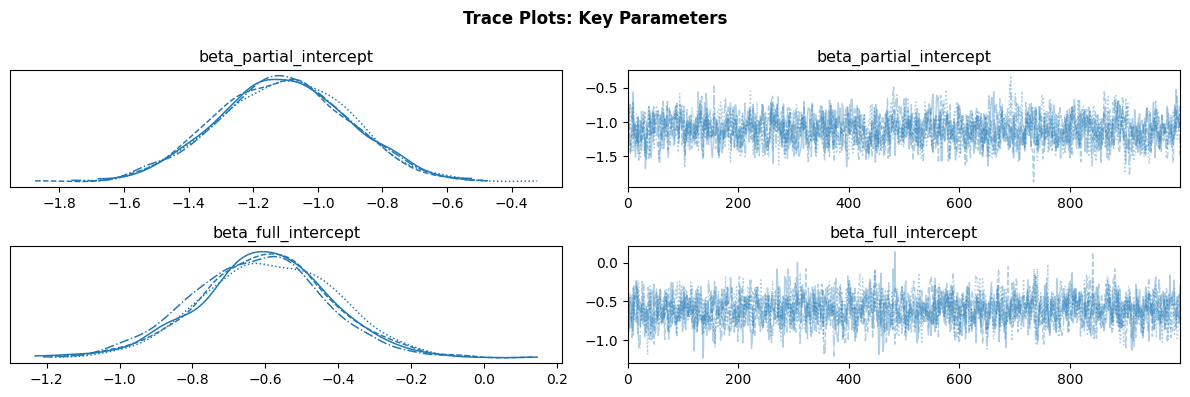

Sampling: [cheating_obs]


Output()

<Axes: xlabel='cheating_obs'>

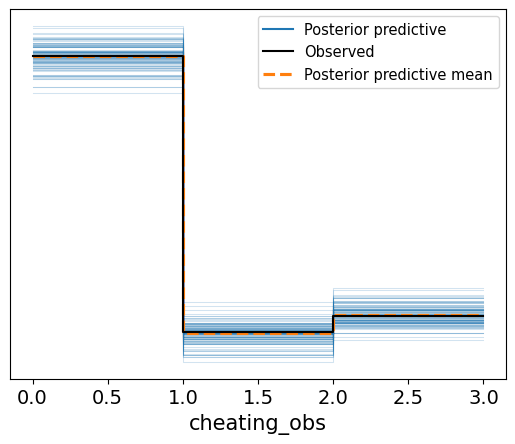

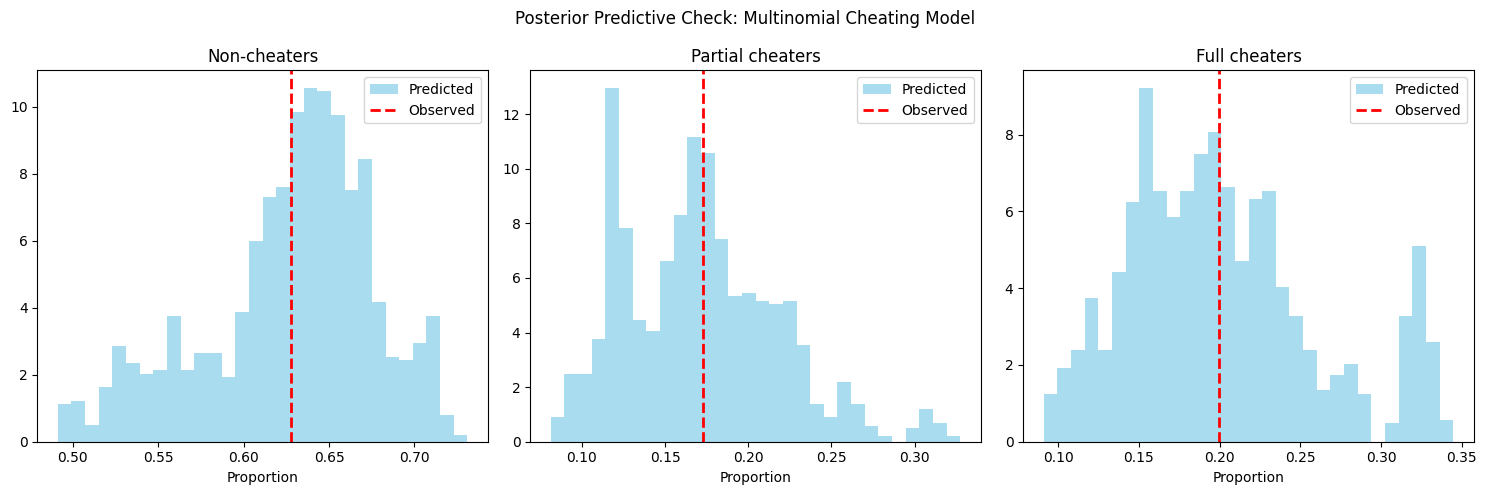

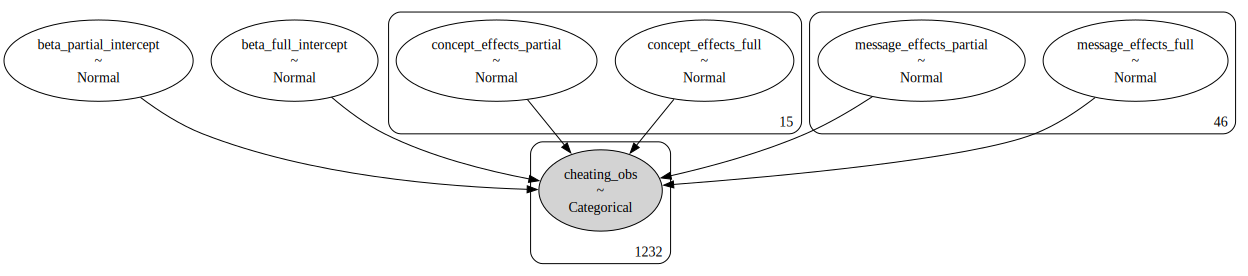

✓ Model diagnostics completed


In [5]:
# ==========================================================================================
# 2.1.1. MODEL DIAGNOSTICS AND VALIDATION
# ==========================================================================================

import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

print("\n" + "="*60)
print("MODEL DIAGNOSTICS")
print("="*60)

# Trace plots
az.plot_trace(cheating_trace, var_names=['beta_partial_intercept', 'beta_full_intercept'], compact=True)
plt.suptitle('Trace Plots: Key Parameters', fontweight='bold')
plt.tight_layout()
plt.show()

# Posterior predictive check
with cheating_effects['model']:
    ppc_cheating = pm.sample_posterior_predictive(cheating_trace, random_seed=42)
    display(az.plot_ppc(ppc_cheating, num_pp_samples=100))

# Custom PPC plots by category
y_cheating_behavior = df['cheating_behavior'].values
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, category in enumerate(['Non-cheaters', 'Partial cheaters', 'Full cheaters']):
    observed_prop = (y_cheating_behavior == i).mean()
    predicted_props = (ppc_cheating.posterior_predictive['cheating_obs'] == i).mean(dim=['chain', 'draw'])
    
    axes[i].hist(predicted_props, bins=30, alpha=0.7, density=True, label='Predicted', color='skyblue')
    axes[i].axvline(observed_prop, color='red', linestyle='--', linewidth=2, label='Observed')
    axes[i].set_title(f'{category}')
    axes[i].set_xlabel('Proportion')
    axes[i].legend()

plt.suptitle('Posterior Predictive Check: Multinomial Cheating Model')
plt.tight_layout()
plt.show()

# Model graph
if 'model' in cheating_effects:
    try:
        with cheating_effects['model']:
            graph = pm.model_to_graphviz()
            display(graph)
    except:
        print("Model graph requires graphviz installation")
else:
    print("Model not available for graph visualization")

print("✓ Model diagnostics completed")


RQ1: CHEATING BEHAVIOR RESULTS TABLE
Concept                             Theory                         Non-cheater               Partial cheater           Full cheater             
---------------------------------------------------------------------------------------------------------------------------------------
OVERALL INTERVENTION EFFECT         All Theories Combined          +12.3 [+5.8, +19.1]       -1.8 [-7.4, +3.9]         -10.5 [-18.1, -3.7]      
---------------------------------------------------------------------------------------------------------------------------------------
Autonomy                            Self-Determination Theory      +13.5 [-1.2, +27.2]       +0.4 [-12.1, +13.1]       -13.9 [-26.6, -1.5]      
Competence                          Self-Determination Theory      +13.3 [-0.9, +26.7]       -4.9 [-14.7, +5.6]        -8.4 [-20.6, +6.3]       
Relatedness                         Self-Determination Theory      +11.7 [-2.6, +25.3]       -5.3 [-14.9, +5.8

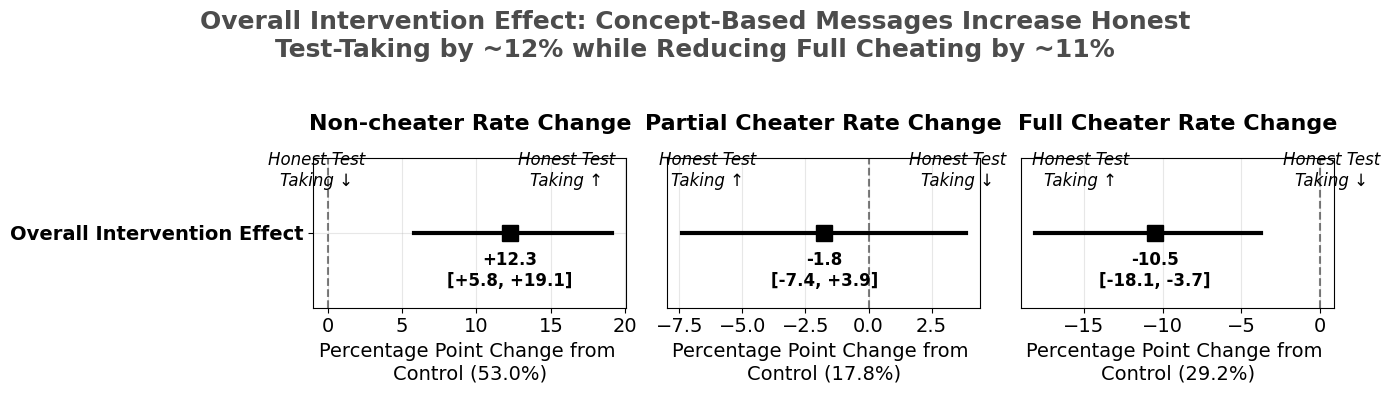

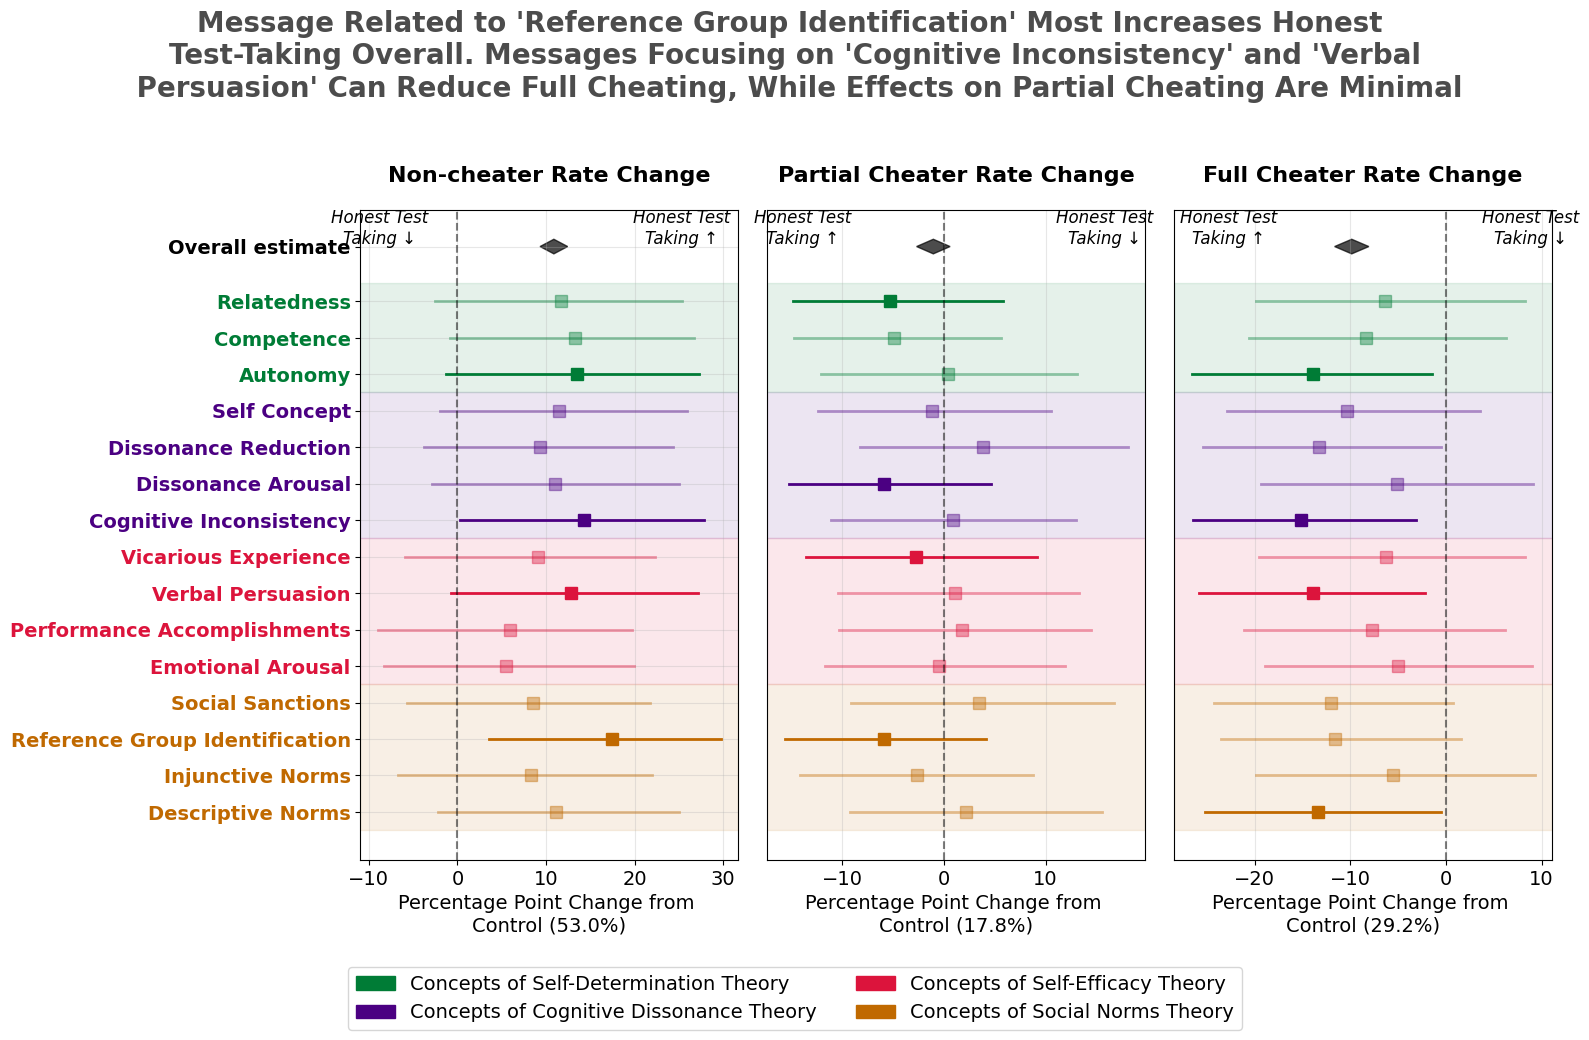

In [6]:
# ==========================================================================================
# 2.2. CHEATING BEHAVIOR SUMMARY STATISTICS (POSTERIOR) AND PLOTS
# ==========================================================================================

from src.visualization.plots import plot_cheating_effects

# Print RQ1 posterior effects table
print("\n" + "="*120)
print("RQ1: CHEATING BEHAVIOR RESULTS TABLE")
print("="*120)

# Header
print(f"{'Concept':<35} {'Theory':<30} {'Non-cheater':<25} {'Partial cheater':<25} {'Full cheater':<25}")
print("-" * 135)

# Overall intervention effect (first row)
overall = cheating_effects['overall_effects']
non_str = f"{overall['Non']['mean']:+.1f} [{overall['Non']['hdi'][0]:+.1f}, {overall['Non']['hdi'][1]:+.1f}]"
partial_str = f"{overall['Partial']['mean']:+.1f} [{overall['Partial']['hdi'][0]:+.1f}, {overall['Partial']['hdi'][1]:+.1f}]"
full_str = f"{overall['Full']['mean']:+.1f} [{overall['Full']['hdi'][0]:+.1f}, {overall['Full']['hdi'][1]:+.1f}]"

print(f"{'OVERALL INTERVENTION EFFECT':<35} {'All Theories Combined':<30} {non_str:<25} {partial_str:<25} {full_str:<25}")
print("-" * 135)

# Individual concepts
concept_results = cheating_effects['concept_effects']
for result in concept_results:
    concept_name = result['concept_label']
    theory = result['theory']
    
    non_str = f"{result['non_mean']:+.1f} [{result['non_hdi'][0]:+.1f}, {result['non_hdi'][1]:+.1f}]"
    partial_str = f"{result['partial_mean']:+.1f} [{result['partial_hdi'][0]:+.1f}, {result['partial_hdi'][1]:+.1f}]"
    full_str = f"{result['full_mean']:+.1f} [{result['full_hdi'][0]:+.1f}, {result['full_hdi'][1]:+.1f}]"
    
    print(f"{concept_name:<35} {theory:<30} {non_str:<25} {partial_str:<25} {full_str:<25}")


plot_cheating_effects(cheating_effects)

### 3. RQ2: PERFORMANCE AND EXPERIENCE ANALYSIS

Answers these two research questions ~
- #### RQ2a: Do the interventions affect performance and user experience?
- #### RQ2b: Do the effects on performance and experience vary by concepts?


We do this by:
- (3.1) Fits multivariate Bayesian model for correlated performance-experience outcomes
    - Moderate Correlations (ρ = 0.4 for control non-cheater) between these two outcomes determined multivariate modeling approach
    - Models concept × cheating category interactions (differential effects)
    - Controls for message variations and accounts for outcome correlation 
- (3.2) Analyzes model results to answer RQ1a and RQ1b
    - Produces Figure: Overall intervention effects
- Key finding: All effects near zero with 95% HDI spanning zero
- Conclusion: Interventions achieve integrity goals without performance/experience costs
"""

In [7]:
# ==========================================================================================
# 3.1. PERFORMANCE AND EXPERIENCE MODEL FITTING (MULTIVARIATE BAYESIAN MODEL)
# ==========================================================================================

"""
REGRESSION EQUATION FOR PERFORMANCE AND EXPERIENCE MODEL:

Multivariate Hierarchical Regression with Correlated Outcomes:

Performance_i = μ_perf_ctrl[cheating_i] + β_perf_main[concept_i] + β_perf_int[concept_i, cheating_i] + γ_perf[message_i] + ε_perf_i
Experience_i = μ_exp_ctrl[cheating_i] + β_exp_main[concept_i] + β_exp_int[concept_i, cheating_i] + γ_exp[message_i] + ε_exp_i

Where (ε_perf_i, ε_exp_i) ~ MVN(0, Σ) with covariance matrix Σ = [[σ²_perf, ρσ_perf σ_exp], [ρσ_perf σ_exp, σ²_exp]]

Variables:
- Dependent Variables: 
  * Performance: performance_score_including_cheated_words (continuous)
  * Experience: (task_satisfaction + task_engagement)/2 (continuous, 1-7 scale)
- Independent Variables:
  * concept_i: Intervention concept indicator (reference = control)
  * cheating_i: Cheating behavior category (0=non, 1=partial, 2=full)
  * message_i: Random effect for motivational message variations
- Parameters:
  * μ_perf_ctrl, μ_exp_ctrl: Control group baselines by cheating category
  * β_perf_main, β_exp_main: Main concept effects
  * β_perf_int, β_exp_int: Concept x cheating category interactions
  * ρ: Performance-experience correlation coefficient
  * σ_perf, σ_exp: Outcome-specific standard deviations

Model accounts for heterogeneous correlation patterns across cheating groups.
"""

from src.models.performance_model import analyze_performance_experience

perf_exp_effects = analyze_performance_experience(df, encoding_info)
perf_exp_trace = perf_exp_effects.get('trace', None)

Decision: 5/6 groups have |r|>0.1
Using multivariate model(s)


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu_perf_ctrl, mu_exp_ctrl, concept_perf_main, concept_exp_main, concept_perf_interactions, concept_exp_interactions, msg_perf, msg_exp, sigma_perf, sigma_exp, rho]
Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 79 seconds.


✓ Performance/experience analysis completed



MODEL DIAGNOSTICS


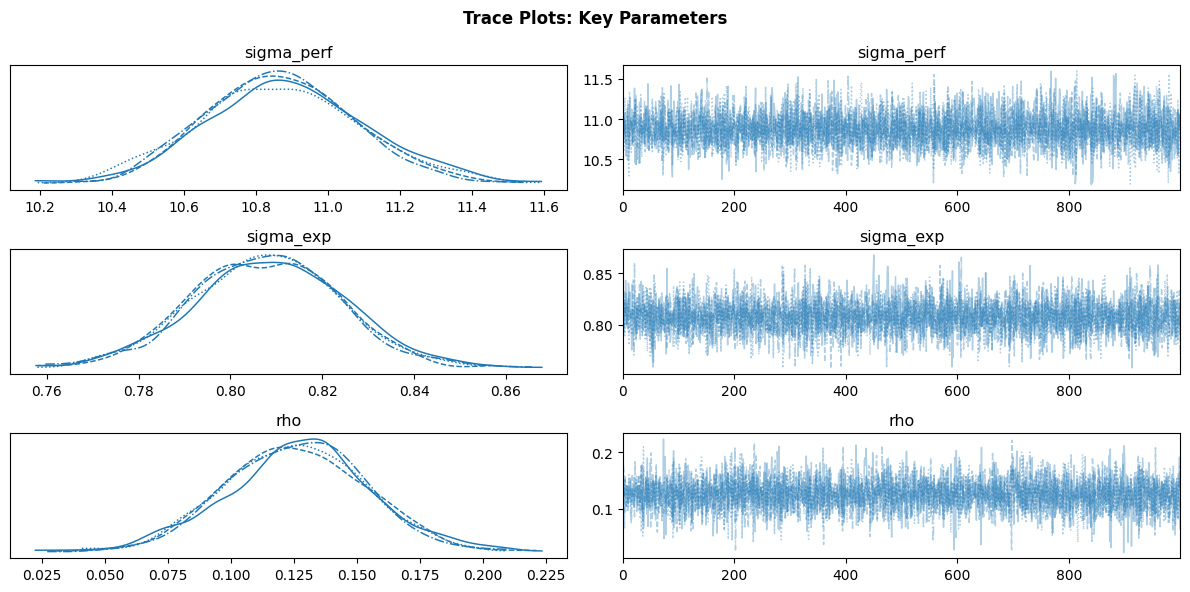

Sampling: [outcomes]


Output()

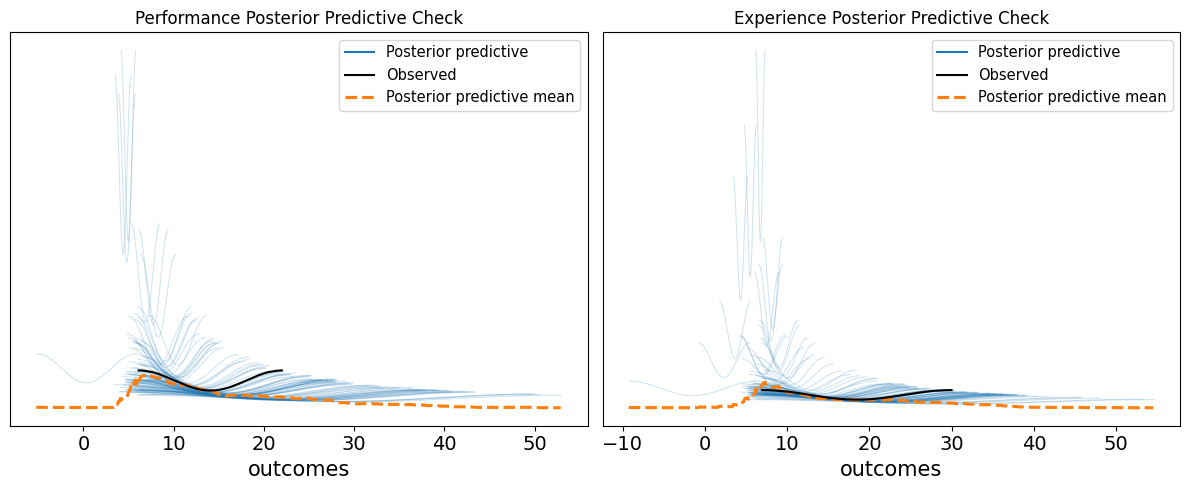

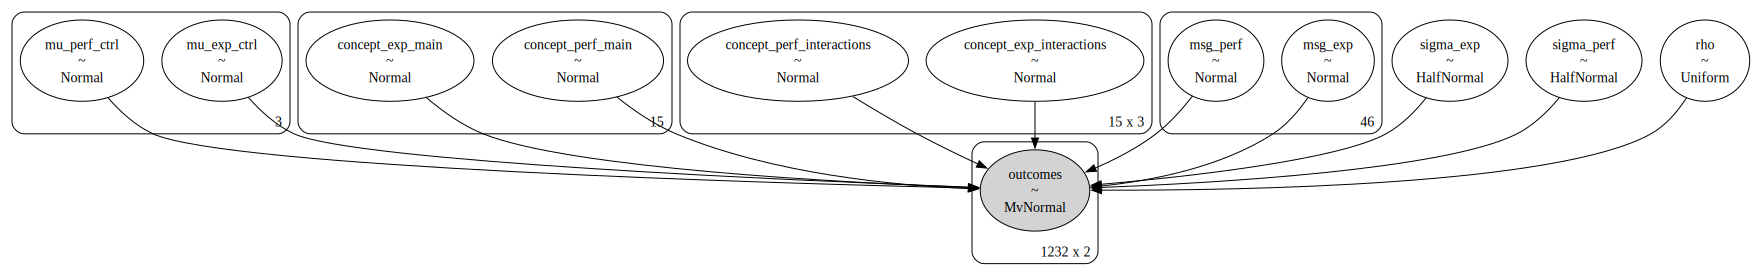

✓ Model diagnostics completed


In [8]:
# ==========================================================================================
# 3.1.1. MODEL DIAGNOSTICS AND VALIDATION
# ==========================================================================================

import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

print("\n" + "="*60)
print("MODEL DIAGNOSTICS")
print("="*60)

# Trace plots for key parameters
az.plot_trace(perf_exp_trace, var_names=['sigma_perf', 'sigma_exp', 'rho'], compact=True)
plt.suptitle('Trace Plots: Key Parameters', fontweight='bold')
plt.tight_layout()
plt.show()

# Posterior predictive check
with perf_exp_effects['model']:
    ppc_perf_exp = pm.sample_posterior_predictive(perf_exp_trace, random_seed=42)
    
    # Performance PPC
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Performance
    az.plot_ppc(ppc_perf_exp, data_pairs={"outcomes": "outcomes"}, 
            num_pp_samples=100, ax=axes[0], coords={"outcomes_dim_0": 1})
    axes[0].set_title('Performance Posterior Predictive Check')
    
    # Experience  
    az.plot_ppc(ppc_perf_exp, data_pairs={"outcomes": "outcomes"}, 
                num_pp_samples=100, ax=axes[1], coords={"outcomes_dim_0": 0})
    axes[1].set_title('Experience Posterior Predictive Check')
    
    plt.tight_layout()
    plt.show()

# Model graph
if 'model' in perf_exp_effects:
    try:
        with perf_exp_effects['model']:
            graph = pm.model_to_graphviz()
            display(graph)
    except:
        print("Model graph requires graphviz installation")

print("✓ Model diagnostics completed")



RQ2: PERFORMANCE AND EXPERIENCE RESULTS TABLE

PERFORMANCE EFFECTS (Raw Score Changes)
Concept                             Theory                         Non-cheater               Partial cheater           Full cheater             
--------------------------------------------------------------------------------------------------------------------------------------------
OVERALL INTERVENTION EFFECT         All Theories Combined          +0.11 [-1.06, +1.21]      -0.10 [-1.36, +0.99]      -0.14 [-1.27, +1.04]     
--------------------------------------------------------------------------------------------------------------------------------------------
Autonomy                            Self-Determination Theory      +0.16 [-2.39, +2.98]      -0.38 [-3.80, +2.83]      -0.74 [-4.16, +2.67]     
Competence                          Self-Determination Theory      +0.34 [-2.30, +2.97]      +0.36 [-3.39, +3.58]      +0.17 [-3.11, +3.30]     
Relatedness                         Self-Determina

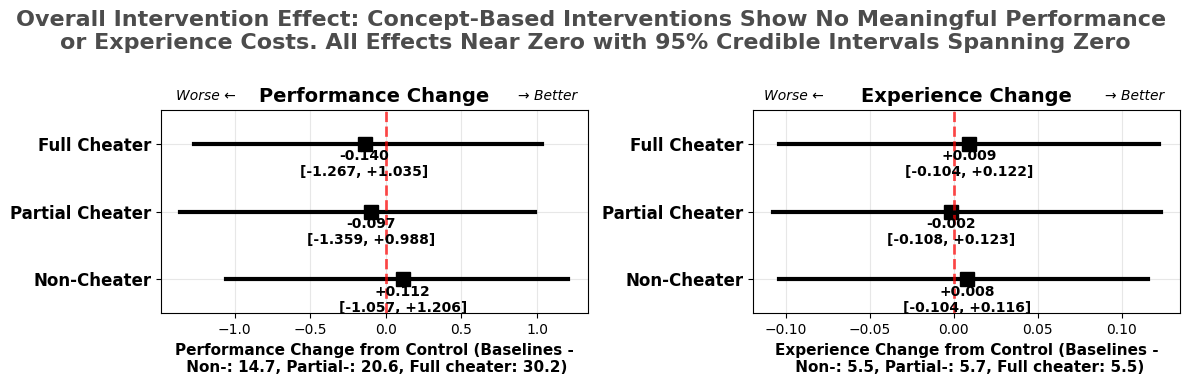

In [9]:
# ==========================================================================================
# 3.2. PERFORMANCE AND EXPERIENCE SUMMARY STATISTICS (POSTERIOR) AND PLOTS
# ==========================================================================================
from src.visualization.plots import plot_performance_experience_effects

# Print RQ2 posterior effects table
print("\n" + "="*150)
print("RQ2: PERFORMANCE AND EXPERIENCE RESULTS TABLE")
print("="*150)

# Performance Table
print("\nPERFORMANCE EFFECTS (Raw Score Changes)")
print(f"{'Concept':<35} {'Theory':<30} {'Non-cheater':<25} {'Partial cheater':<25} {'Full cheater':<25}")
print("-" * 140)

# Overall intervention effect (first row)
if 'multivariate_results' in perf_exp_effects:
    overall = perf_exp_effects['multivariate_results']
    perf_non_str = f"{overall['perf_non']['mean']:+.2f} [{overall['perf_non']['hdi'][0]:+.2f}, {overall['perf_non']['hdi'][1]:+.2f}]"
    perf_partial_str = f"{overall['perf_partial']['mean']:+.2f} [{overall['perf_partial']['hdi'][0]:+.2f}, {overall['perf_partial']['hdi'][1]:+.2f}]"
    perf_full_str = f"{overall['perf_full']['mean']:+.2f} [{overall['perf_full']['hdi'][0]:+.2f}, {overall['perf_full']['hdi'][1]:+.2f}]"
    
    print(f"{'OVERALL INTERVENTION EFFECT':<35} {'All Theories Combined':<30} {perf_non_str:<25} {perf_partial_str:<25} {perf_full_str:<25}")
    print("-" * 140)
    
    # Individual concepts
    if 'concept_effects' in perf_exp_effects:
        concept_results = perf_exp_effects['concept_effects']
        for result in concept_results:
            concept_name = result['concept_label']
            theory = result['theory']
            
            perf_non_str = f"{result['perf_non_mean']:+.2f} [{result['perf_non_hdi'][0]:+.2f}, {result['perf_non_hdi'][1]:+.2f}]"
            perf_partial_str = f"{result['perf_partial_mean']:+.2f} [{result['perf_partial_hdi'][0]:+.2f}, {result['perf_partial_hdi'][1]:+.2f}]"
            perf_full_str = f"{result['perf_full_mean']:+.2f} [{result['perf_full_hdi'][0]:+.2f}, {result['perf_full_hdi'][1]:+.2f}]"
            
            print(f"{concept_name:<35} {theory:<30} {perf_non_str:<25} {perf_partial_str:<25} {perf_full_str:<25}")

# Experience Table
print("\n" + "="*150)
print("EXPERIENCE EFFECTS (7-point Scale Changes)")
print(f"{'Concept':<35} {'Theory':<30} {'Non-cheater':<25} {'Partial cheater':<25} {'Full cheater':<25}")
print("-" * 140)

# Overall intervention effect (first row)
if 'multivariate_results' in perf_exp_effects:
    exp_non_str = f"{overall['exp_non']['mean']:+.3f} [{overall['exp_non']['hdi'][0]:+.3f}, {overall['exp_non']['hdi'][1]:+.3f}]"
    exp_partial_str = f"{overall['exp_partial']['mean']:+.3f} [{overall['exp_partial']['hdi'][0]:+.3f}, {overall['exp_partial']['hdi'][1]:+.3f}]"
    exp_full_str = f"{overall['exp_full']['mean']:+.3f} [{overall['exp_full']['hdi'][0]:+.3f}, {overall['exp_full']['hdi'][1]:+.3f}]"
    
    print(f"{'OVERALL INTERVENTION EFFECT':<35} {'All Theories Combined':<30} {exp_non_str:<25} {exp_partial_str:<25} {exp_full_str:<25}")
    print("-" * 140)
    
    # Individual concepts
    if 'concept_effects' in perf_exp_effects:
        for result in concept_results:
            concept_name = result['concept_label']
            theory = result['theory']
            
            exp_non_str = f"{result['exp_non_mean']:+.3f} [{result['exp_non_hdi'][0]:+.3f}, {result['exp_non_hdi'][1]:+.3f}]"
            exp_partial_str = f"{result['exp_partial_mean']:+.3f} [{result['exp_partial_hdi'][0]:+.3f}, {result['exp_partial_hdi'][1]:+.3f}]"
            exp_full_str = f"{result['exp_full_mean']:+.3f} [{result['exp_full_hdi'][0]:+.3f}, {result['exp_full_hdi'][1]:+.3f}]"
            
            print(f"{concept_name:<35} {theory:<30} {exp_non_str:<25} {exp_partial_str:<25} {exp_full_str:<25}")

# Plot effects
plot_performance_experience_effects(perf_exp_effects)

### 4. RQ3: How do concept-based interventions influence cheating behavior, performance and user experience?

We aim to understand if concept-based interventions work through desired psychological pathways?

- (5.1) PATHWAY ANALYSIS:
    - Tests coefficients in two pathways: {Concepts → Psychological Mechanisms} and {Psychological Mechanisms → Outcomes}
    - Analyzes 5 psychological mechanisms (Need Satisfaction, Need Frustration, Self-Efficacy, Norm Perception, Cognitive Discomfort)
    - Separate models for each pathway to isolate effects
    - Key finding: Limited mediation - mechanisms weakly activated and inconsistently predict outcomes

- (5.2) NETWORK ANALYSIS:
    - Maps correlational structures between mechanisms and outcomes
    - Compares psychological networks: control vs intervention vs individual concepts
    - Uses partial correlations to identify direct relationships
    - Reveals concept-specific mechanism activation patterns
    - Shows how different theories create different psychological network structures
"""

Analysis Strategy:
1. Overall Intervention → Psychological Mechanisms
2. Psychological Mechanisms → Cheating Behavior
3. Psychological Mechanisms → Performance/Experience

PATHWAY ANALYSIS VARIABLE CHECK
PSYCHOLOGICAL MECHANISMS:
✓ Need Satisfaction: 1232 values
✓ Need Frustration: 1232 values
✓ Self Efficacy: 1232 values
✓ Norm Perception: 1232 values
✓ Discomfort: 1232 values

Analyzing pathways with 5 mechanisms

Fitting: Individual Concepts → Psychological Mechanisms
Fitting: Psychological Mechanisms → Cheating Behavior


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_partial_intercept, beta_full_intercept, mech_effects_partial, mech_effects_full]
Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 8 seconds.


Fitting: Psychological Mechanisms → Performance/Experience


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [perf_mech_effects, exp_mech_effects, perf_baseline, exp_baseline, perf_sigma, exp_sigma]
Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 19 seconds.


✓ Pathway analysis completed


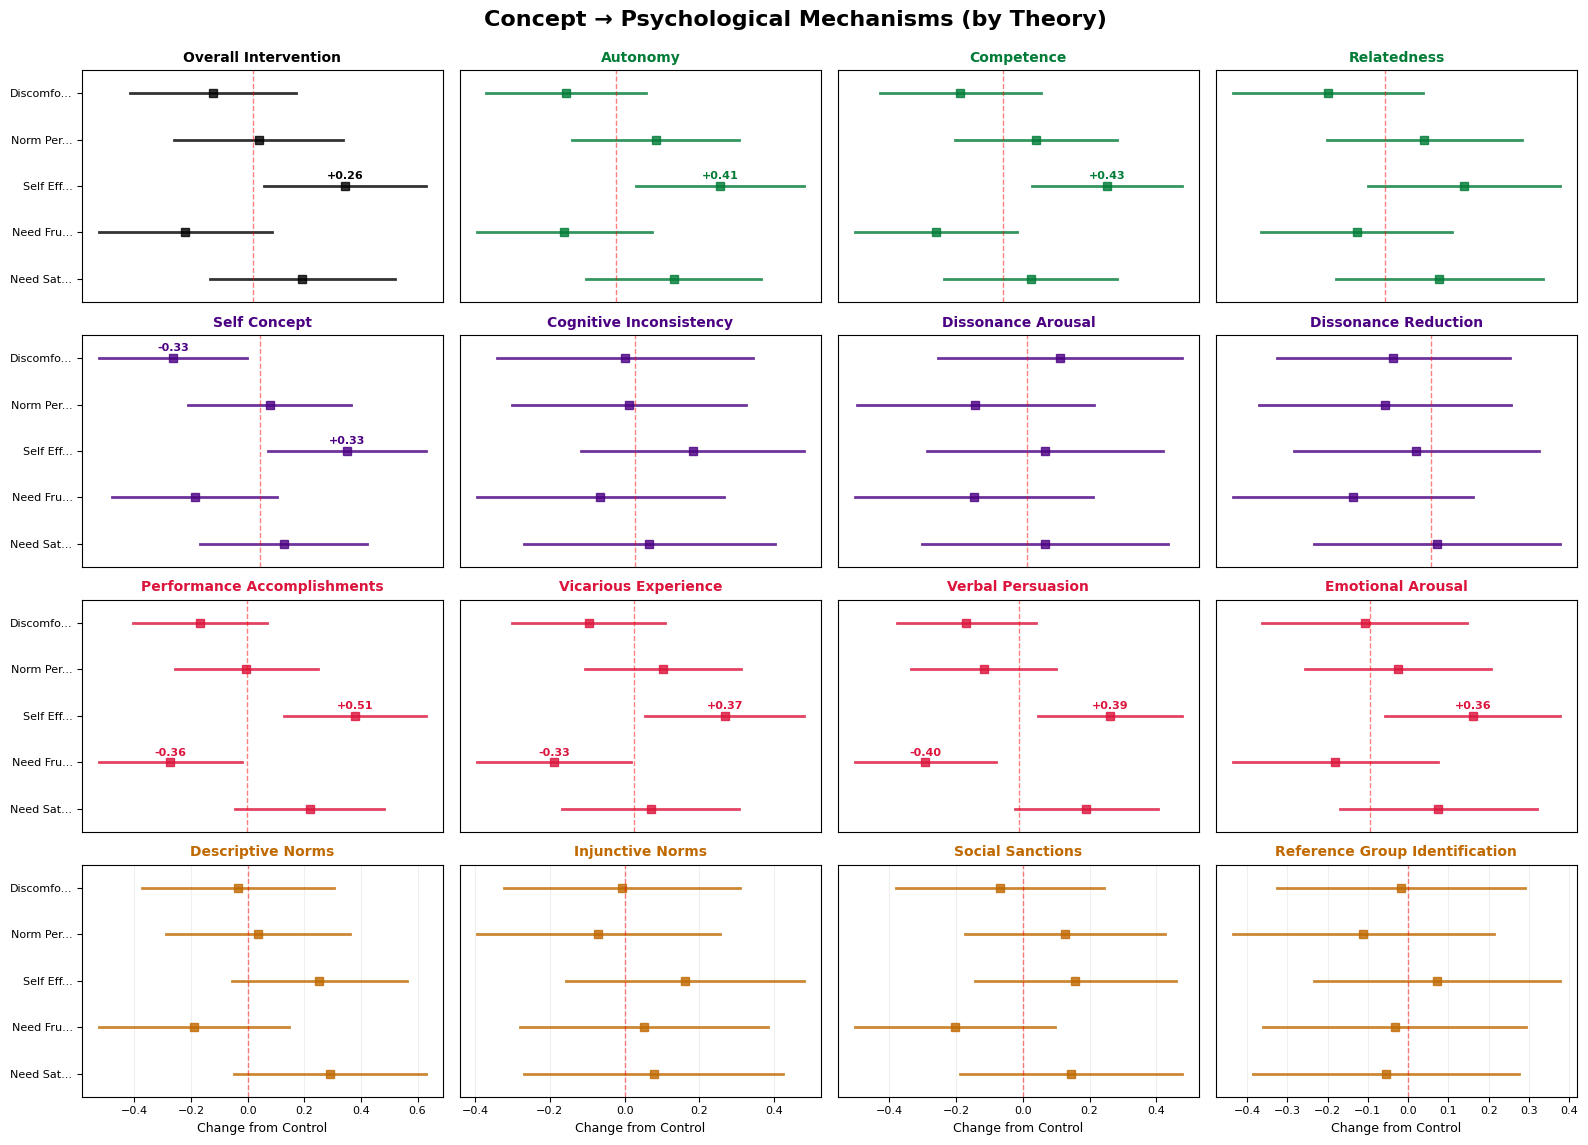

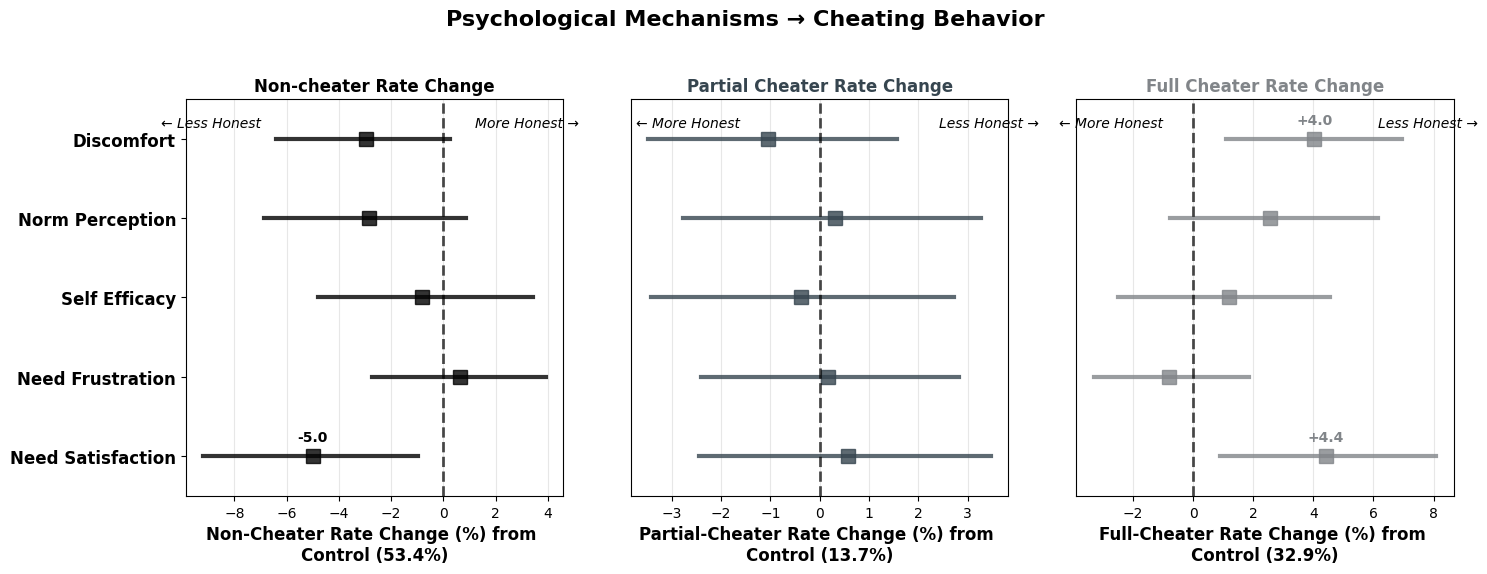

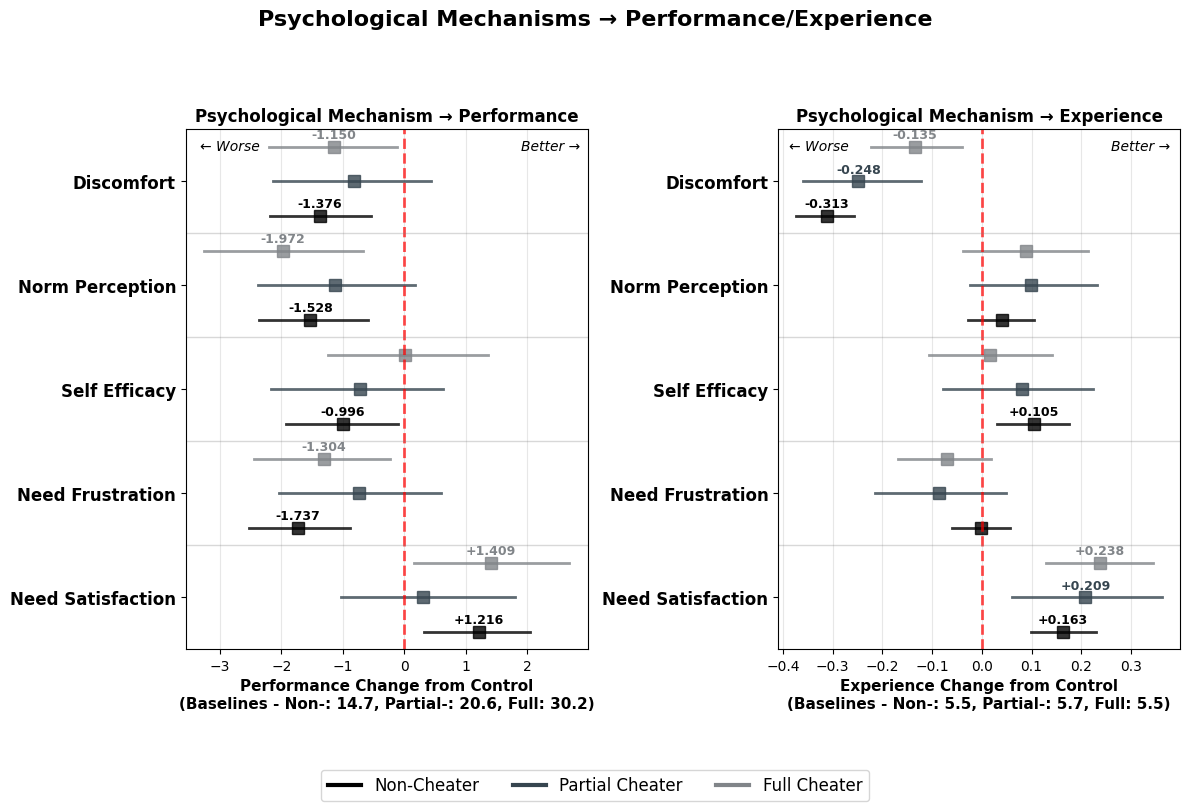


PATHWAY ANALYSIS RESULTS

1. OVERALL INTERVENTION → PSYCHOLOGICAL MECHANISMS
Mechanism                 Effect Size          95% HDI                  
----------------------------------------------------------------------

2. PSYCHOLOGICAL MECHANISMS → CHEATING BEHAVIOR
Mechanism            Non-Cheater               Partial Cheater           Full Cheater             
-----------------------------------------------------------------------------------------------
Need Satisfaction    -5.0% [-9.2, -1.0]        +0.6% [-2.5, +3.5]        +4.4% [+0.9, +8.1]       
Need Frustration     +0.6% [-2.7, +3.9]        +0.2% [-2.4, +2.8]        -0.8% [-3.3, +1.9]       
Self Efficacy        -0.8% [-4.8, +3.4]        -0.4% [-3.4, +2.7]        +1.2% [-2.5, +4.5]       
Norm Perception      -2.9% [-6.9, +0.9]        +0.3% [-2.8, +3.3]        +2.6% [-0.8, +6.1]       
Discomfort           -3.0% [-6.4, +0.3]        -1.1% [-3.5, +1.6]        +4.0% [+1.1, +6.9]       

3. PSYCHOLOGICAL MECHANISMS → PERFORMA

In [10]:
# ========================================================================================================
# 4.1. SEPARATE PATHWAY ANALYSIS 
# (CONCEPTS → PSYCHOLOGICAL MECHANISMS) (PSYCHOLOGICAL MECHANISMS → CHEATING BEHAVIOR, PERFORMANCE, EXPERIENCE)
# ========================================================================================================

"""
REGRESSION EQUATIONS FOR PATHWAY ANALYSIS:

MODEL 1 - CONCEPTS → PSYCHOLOGICAL MECHANISMS (PATHWAY 1):
Mechanism_i = β₀[cheating_i] + αⱼ[concept_j, cheating_i] + γₖ[message_k] + ε_i

MODEL 2 - PSYCHOLOGICAL MECHANISMS → CHEATING BEHAVIOR (PATHWAY 2a):
log(P(Partial)/P(Non)) = β₀_partial + Σ(δₘ x Mechanism_m)
log(P(Full)/P(Non))    = β₀_full + Σ(ζₘ x Mechanism_m)

MODEL 3 - PSYCHOLOGICAL MECHANISMS → PERFORMANCE/EXPERIENCE (PATHWAY 2b):
Performance_i = β₀_perf[cheating_i] + Σ(θₘ[cheating_i] x Mechanism_m) + ε_perf_i
Experience_i = β₀_exp[cheating_i] + Σ(ψₘ[cheating_i] x Mechanism_m) + ε_exp_i

Where:
- Mechanisms: Need Satisfaction, Need Frustration, Self-Efficacy, Norm Perception, Cognitive Discomfort
- All mechanisms are standardized (z-scores)
- PATHWAY 1 tests concept → mechanism activation
- PATHWAY 2,3 test mechanism → outcome relationships
- Models are stratified by cheating behavior groups for differential effects

This approach separates mediation pathways to identify which psychological mechanisms
are activated by interventions and which mechanisms influence outcomes.
"""

from src.models.pathway_model import analyze_psychological_pathways
from src.visualization.plots import plot_pathway_effects, print_pathway_summary

print("Analysis Strategy:")
print("1. Overall Intervention → Psychological Mechanisms")
print("2. Psychological Mechanisms → Cheating Behavior")  
print("3. Psychological Mechanisms → Performance/Experience")

# Analyze pathways
pathway_results = analyze_psychological_pathways(df, encoding_info)

if pathway_results:
    # Create all pathway plots
    plot_pathway_effects(pathway_results)
    
    # Print detailed results tables
    print_pathway_summary(pathway_results)
else:
    print("Pathway analysis not possible with available data")
    print("RQ3.2: Cannot determine psychological pathways with current variables")

Networks estimated for 17 groups
Network variables: ['need_satisfaction', 'need_frustration', 'self_efficacy', 'norm_perception', 'cognitive_discomfort', 'cheating', 'performance', 'experience']


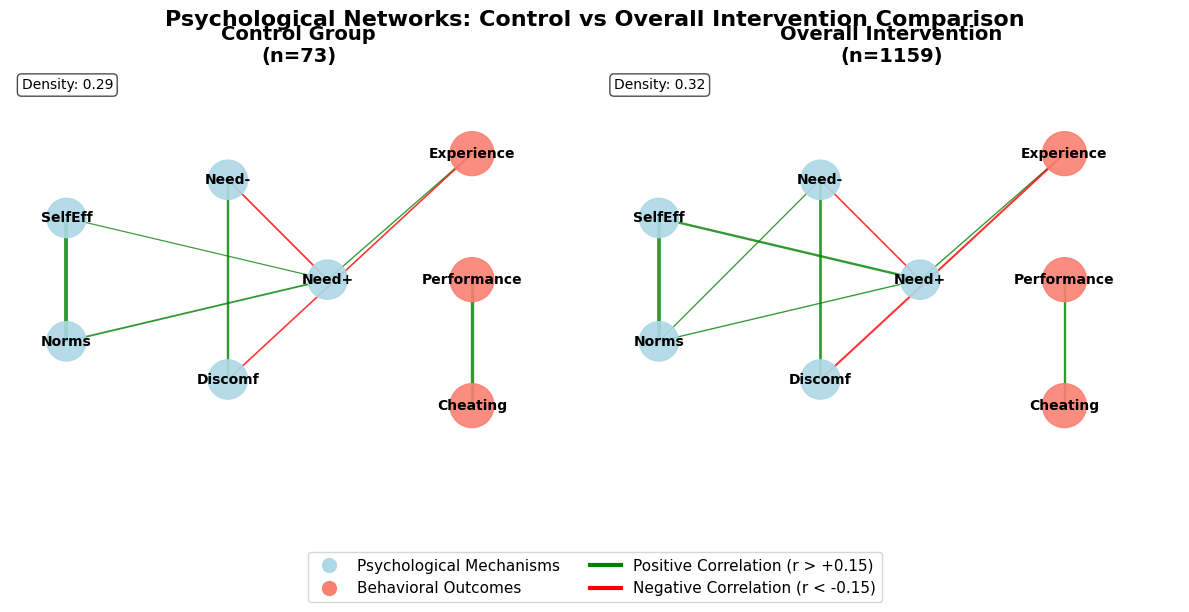

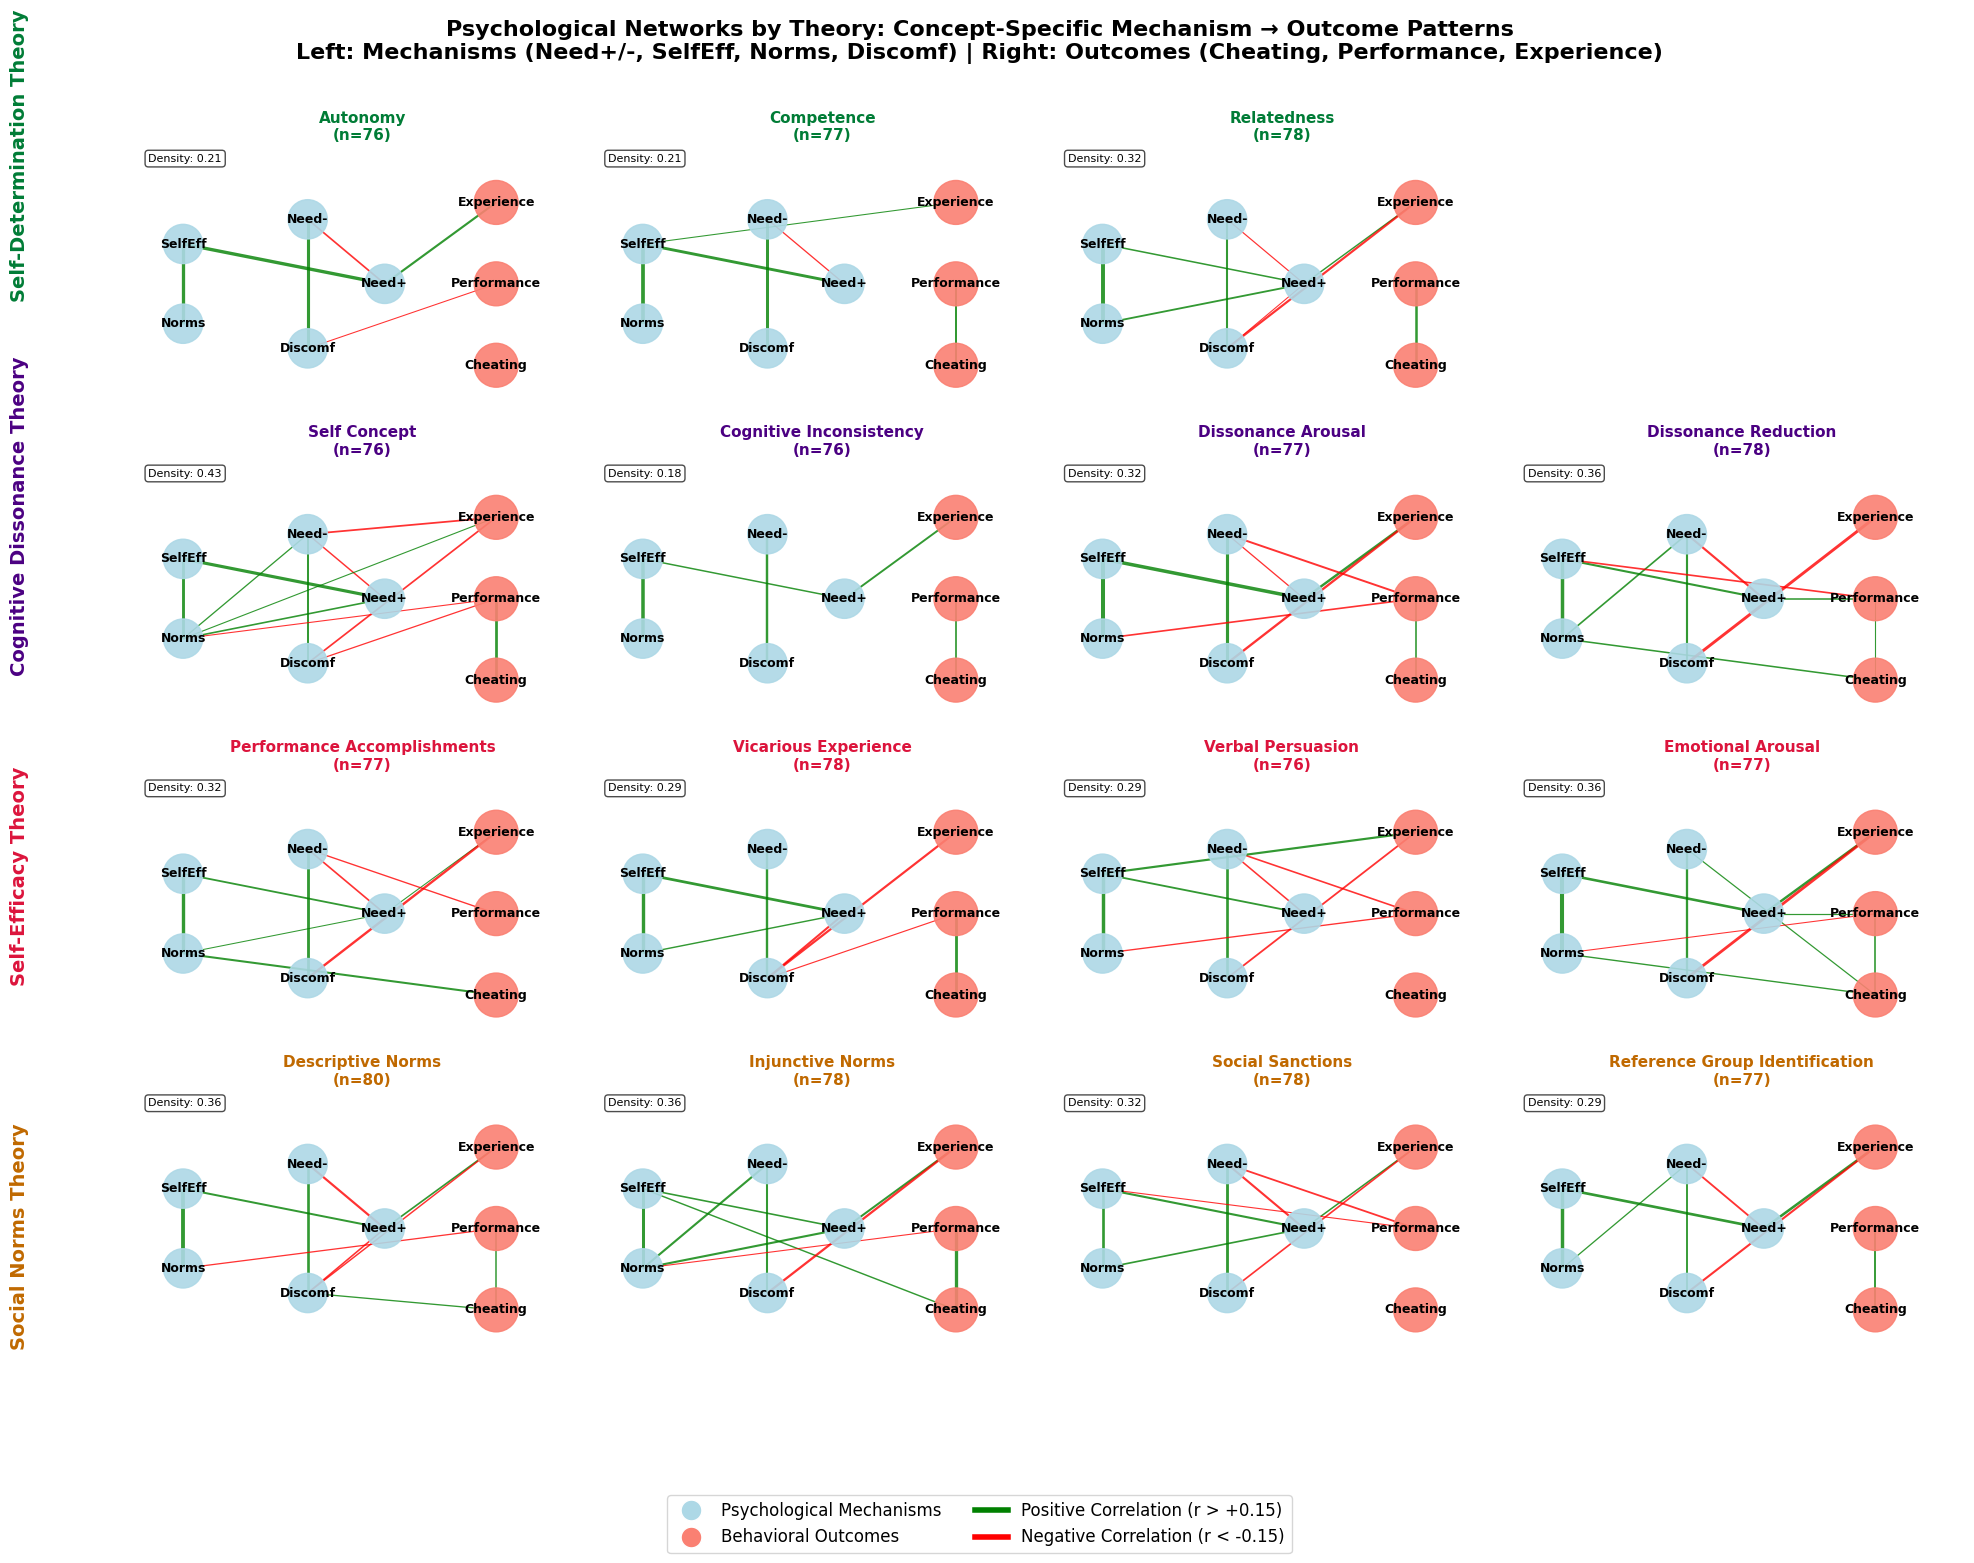


PARTIAL CORRELATION MATRICES

CONTROL:
----------------------------------------
                      need_satisfaction  need_frustration  self_efficacy  norm_perception  cognitive_discomfort  cheating  performance  experience
need_satisfaction                 0.000            -0.254          0.171            0.260                -0.085     0.000        0.053       0.191
need_frustration                 -0.254             0.000          0.000            0.150                 0.358     0.000       -0.000      -0.009
self_efficacy                     0.171             0.000          0.000            0.560                -0.000     0.000       -0.000       0.017
norm_perception                   0.260             0.150          0.560            0.000                -0.000     0.000       -0.000       0.074
cognitive_discomfort             -0.085             0.358         -0.000           -0.000                 0.000     0.000       -0.095      -0.232
cheating                          0.0

In [11]:
# ============================================================================
# 4.2. PSYCHOLOGICAL NETWORKS ANALYSIS  
# ============================================================================

from src.models.network_model import analyze_networks_by_concept, get_partial_correlation_tables
from src.visualization.plots import plot_concept_networks_two_plots, print_partial_correlation_tables
import numpy as np

# Analyze networks for control + all individual concepts
network_results, labels = analyze_networks_by_concept(df)

# Add overall intervention network by combining all intervention data
from src.models.network_model import prepare_network_data, estimate_partial_correlations

network_data = prepare_network_data(df)
intervention_data = network_data[df['concept'] != 'control']

if len(intervention_data) >= 10:
    partial_corr = estimate_partial_correlations(intervention_data)
    network_results['overall_intervention'] = {
        'partial_correlations': partial_corr,
        'n_participants': len(intervention_data)
    }

print(f"Networks estimated for {len(network_results)} groups")
print(f"Network variables: {labels}")

# Create both plots: Control vs Overall + Theory grid
plot_concept_networks_two_plots(network_results, labels)

# Extract partial correlation tables
correlation_tables = get_partial_correlation_tables(network_results, labels)

# Print correlation matrices
print_partial_correlation_tables(correlation_tables)

print("\n" + "="*60)
print("NETWORK ANALYSIS SUMMARY")
print("="*60)

# Compare control vs overall intervention vs individual concepts
if 'control' in correlation_tables and 'overall_intervention' in correlation_tables:
    control_corrs = correlation_tables['control']
    overall_corrs = correlation_tables['overall_intervention']
    
    control_density = np.abs(control_corrs.values).mean()
    overall_density = np.abs(overall_corrs.values).mean()
    
    print(f"Control network density: {control_density:.3f}")
    print(f"Overall intervention density: {overall_density:.3f}")
    print(f"Density difference: {overall_density - control_density:+.3f}")

# Individual concept densities
individual_concepts = [c for c in correlation_tables.keys() 
                      if c not in ['control', 'overall_intervention']]

if individual_concepts:
    individual_densities = []
    for concept in individual_concepts:
        density = np.abs(correlation_tables[concept].values).mean()
        individual_densities.append(density)
    
    avg_individual_density = np.mean(individual_densities)
    print(f"Average individual concept density: {avg_individual_density:.3f}")

# Strongest mechanism-outcome connections
if 'overall_intervention' in correlation_tables:
    print(f"\nStrongest mechanism→outcome connections (Overall Intervention):")
    
    overall_matrix = correlation_tables['overall_intervention'].values
    strongest_connections = []
    
    mechanism_names = ['need_satisfaction', 'need_frustration', 'self_efficacy', 'norm_perception', 'cognitive_discomfort']
    outcome_names = ['cheating', 'performance', 'experience']
    
    for mech in mechanism_names:
        for outcome in outcome_names:
            if mech in labels and outcome in labels:
                mech_idx = labels.index(mech)
                outcome_idx = labels.index(outcome) 
                corr = overall_matrix[mech_idx, outcome_idx]
                strongest_connections.append((mech, outcome, abs(corr), corr))
    
    strongest_connections.sort(key=lambda x: x[2], reverse=True)
    for mech, outcome, abs_corr, corr in strongest_connections[:8]:  # Top 8
        print(f"  {mech} → {outcome}: {corr:+.3f}")

print("\n✓ Network analysis completed")